In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import mlflow

In [ ]:
# Lancer MLFlow sur le port 5001 : mlflow ui --port 5001
#mlflow.set_tracking_uri("http://127.0.0.1:5001")
mlflow.set_experiment("Monitoring des train des modèles PCO")

# SVC

In [2]:
arr_algo_1 = np.load('array_algo_1.npy', allow_pickle=True)
arr_algo_1[0, 0:5]

array([8600432.0, 'Description du poste', 0, 0.24681146442890167,
       0.05224579572677612], dtype=object)

In [3]:
df_algo_1 = pd.DataFrame(arr_algo_1)
nb_cat_bin = df_algo_1[2].value_counts()
nb_cat_bin

2
1    1859
0    1752
Name: count, dtype: int64

## Préparation du dataset

In [4]:
X = arr_algo_1[:, 3:] # vecteurs d'embedding
Y = arr_algo_1[:, 2] # variable cible 0 / 1

In [5]:
X = X.astype(float)
Y = Y.astype(int)
print(X.dtype)
print(Y.dtype)

float64
int32


In [6]:
# seed random
import random

seed = random.randint(0, 1000)
print(f"Seed utilisée : {seed}")

Seed utilisée : 820


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=seed, stratify=Y)

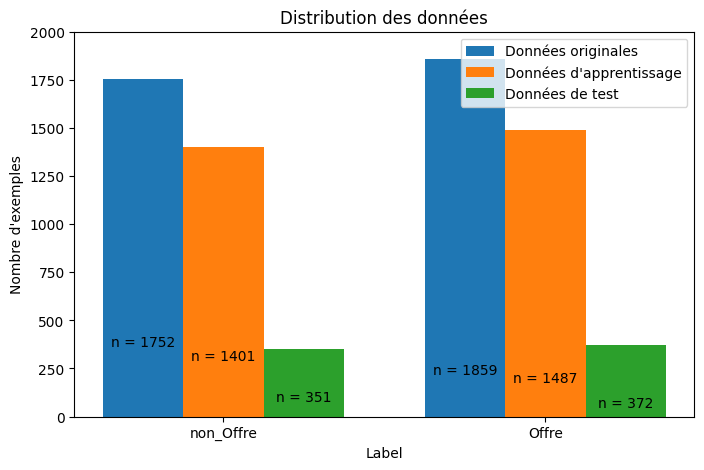

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5), dpi=100)

plt.title("Distribution des données")

plt.hist([Y, y_train, y_test],
         bins = [x - 0.5 for x in range(0, 3)],
         rwidth=0.75,
         label=["Données originales", "Données d'apprentissage", "Données de test"])

plt.annotate("n = " + str(np.sum(Y == 0)), (-0.25, 365.0), ha='center')
plt.annotate("n = " + str(np.sum(y_train == 0)), (0.0, 293.0), ha='center')
plt.annotate("n = " + str(np.sum(y_test == 0)), (0.25, 80.0), ha='center')

plt.annotate("n = " + str(np.sum(Y == 1)), (0.75, 220.0), ha='center')
plt.annotate("n = " + str(np.sum(y_train == 1)), (1.0, 178.0), ha='center')
plt.annotate("n = " + str(np.sum(y_test == 1)), (1.25, 50.0), ha='center')

plt.xticks(np.arange(2), ("non_Offre", "Offre"))

plt.xlabel("Label")
plt.ylabel("Nombre d'exemples")

plt.ylim(0.0, 2000.0)

plt.legend()

plt.show()

## Standardisation des données

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Recherche meilleurs hyperparamètres

In [10]:
from sklearn.svm import SVC

In [11]:
# GridsearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
                    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                     'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                      'gamma' : ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10, 100]
             }

model = SVC(random_state=seed)


grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, scoring='accuracy',
                           n_jobs=-1, verbose=2)

grid_search.fit(scaled_X_train, y_train)

# Afficher les meilleurs paramètres trouvés
print(f"Meilleurs paramètres : {grid_search.best_params_}")


Fitting 5 folds for each of 224 candidates, totalling 1120 fits
Meilleurs paramètres : {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}


# Entrainement avec meilleurs hyperparamètres

In [13]:
svc = SVC(C= 1,
         kernel= 'rbf',
         gamma= 0.001
         )

svc.fit(X_train, y_train)

SVC(C=1, gamma=0.001)

## Prédictions jeu de train

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [15]:
y_pred_train = svc.predict(X_train)

In [16]:
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
f1_train = f1_score(y_train, y_pred_train)

print('Accuracy:', accuracy_train)
print('Precision:', precision_train)
print('Recall:', recall_train)
print('F1-score:', f1_train)

Accuracy: 0.8528393351800554
Precision: 0.8636986301369863
Recall: 0.8480161398789509
F1-score: 0.855785544621649


In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, y_pred_train, labels=svc.classes_, normalize='true')

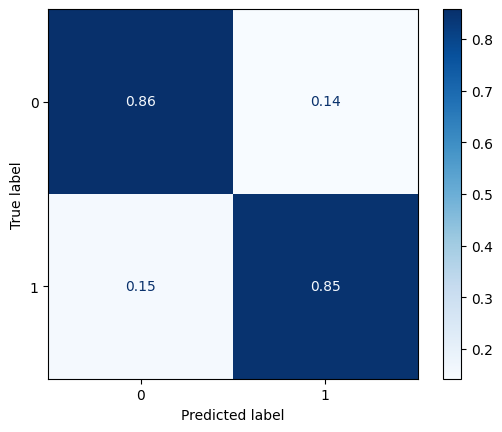

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svc.classes_, )                                          
disp.plot(cmap='Blues')

plt.show()

## Prédictions jeu de test

In [20]:
y_pred = svc.predict(X_test)

In [21]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [22]:
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)

Accuracy: 0.8395573997233748
Precision: 0.845945945945946
Recall: 0.8413978494623656
F1-score: 0.8436657681940701


In [ ]:
with mlflow.start_run(run_name="Training_svc_1"):
    mlflow.log_metric("test_accuracy_svc_1", accuracy)
    # Autres logs pour le modèle (ex: hyperparamètres, modèle lui-même)
    mlflow.sklearn.log_model(svc, "svc_1")

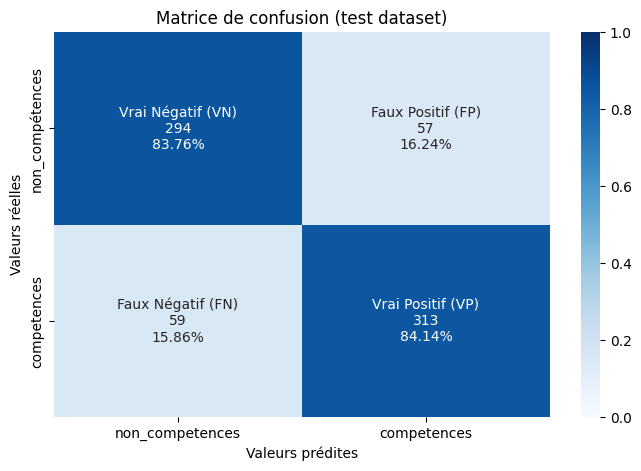

In [23]:
import seaborn as sns

names = ['Vrai Négatif (VN)', 'Faux Positif (FP)','Faux Négatif (FN)', 'Vrai Positif (VP)']
counts = ["{0:0.0f}\n".format(value) for value in confusion_matrix(y_test, y_pred, normalize=None).flatten()]
percentages = ["{0:.2%}".format(value) for value in confusion_matrix(y_test, y_pred, normalize='true').flatten()]

box_labels = [f"{v1}\n{v2}{v3}" for v1, v2, v3 in zip(names, counts, percentages)]
box_labels = np.asarray(box_labels).reshape(cm.shape[0],cm.shape[1])

plt.figure(figsize=(8,5), dpi=100)

plt.title("Matrice de confusion (test dataset)")

sns.heatmap(cm,
            vmin=0.0,
            vmax=1.0,
            cmap='Blues',
            annot=box_labels,
            fmt='',
            xticklabels=['non_competences', 'competences'],
            yticklabels=['non_compétences', 'competences'])

plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")

plt.show()

## Observations des mauvaises prédictions

In [ ]:
df_train, df_test = train_test_split(df_algo_1, test_size=0.20, random_state=seed, stratify=Y)
df_test['true']=y_test
df_test['pred']=y_pred

In [ ]:
# Faux négatifs
df_test.loc[(df_test['true'] == 1) & (df_test['pred'] == 0)]

In [ ]:
# Faux positifs
df_test.loc[(df_test['true'] == 0) & (df_test['pred'] == 1)]

## Enregistrement du modèle

In [ ]:
import joblib
from joblib import dump

#dump(svc, 'svc_1.joblib')